In [34]:
import torch
import torch.nn as nn
import torch.optim as optim
from torch.utils.data import DataLoader, Subset
import torchvision.models as models
import torchvision.transforms as transforms
import torchvision.datasets as datasets
from torch.utils.tensorboard import SummaryWriter
import numpy as np
import matplotlib.pyplot as plt
import seaborn as sns
from sklearn.metrics import confusion_matrix
from tqdm import tqdm
from datetime import datetime
import random
import os
import time
import pandas as pd

### Helper Functions

##### Note: To write multiline function descriptions, we took help from ChatGPT

In [50]:
def load_model(model_name, weights_path, num_classes=2, device=None):
    """
    Load a pre-trained model with modified classification layers and custom weights.
    
    Args:
        model_name (str): The name of the model ('resnet', 'squeezenet', 'convnext', 'vit', 'mobilenetv2').
        weights_path (str): Path to the trained weights file.
        num_classes (int): Number of output classes (default is 2).
        device (torch.device, optional): Device to load the model onto. Defaults to auto-detect.

    Returns:
        model: The loaded and modified model.
    """
    # Default to auto-detecting the device
    if device is None:
        device = torch.device("cuda" if torch.cuda.is_available() else "cpu")
    
    # Initialize the model
    if model_name == "resnet":
        model = models.resnet50(pretrained=False)
        model.fc = nn.Linear(model.fc.in_features, num_classes)
    elif model_name == "squeezenet":
        model = models.squeezenet1_1(pretrained=False)
        model.classifier[1] = nn.Conv2d(512, num_classes, kernel_size=1)
    elif model_name == "convnext":
        model = models.convnext_base(pretrained=False)
        model.classifier[2] = nn.Linear(model.classifier[2].in_features, num_classes)
    elif model_name == "vit":
        model = models.vit_b_16(pretrained=False)
        model.heads.head = nn.Linear(model.heads.head.in_features, num_classes)
    elif model_name == "mobilenetv2":
        model = models.mobilenet_v2(pretrained=False)
        model.classifier[1] = nn.Linear(model.classifier[1].in_features, num_classes)
    else:
        raise ValueError(f"Unsupported model name: {model_name}")

    # Load the state dictionary
    state_dict = torch.load(weights_path, map_location=device)
    model.load_state_dict(state_dict)

    # Move the model to the device
    model.to(device)

    # Set the model to evaluation mode for inference
    model.eval()

    print(f"{model_name.capitalize()} model loaded successfully.")
    return model

def plot_performance(df, modelName):
    """
    Plot performance for the model.
    """
    train_losses = df['Train Loss'].values
    test_losses = df['Test Loss'].values
    train_accuracies = df['Train Accuracy'].values
    test_accuracies = df['Test Accuracy'].values

    x_value = df.index+1
    
    plt.figure(figsize=(12, 5))
    
    # Plot Train Loss vs Test Loss
    plt.subplot(1, 2, 1)
    plt.plot(x_value, train_losses, label='Train Loss', marker='o', markeredgecolor='black')
    plt.plot(x_value, test_losses, label='Test Loss', marker='o', markeredgecolor='black')
    plt.xlabel('Epoch')
    plt.ylabel('Loss')
    plt.legend()
    plt.axvline(x=5.5, color="green", ls="--", linewidth=2)
    plt.title(f'{modelName} Loss')
    
    # Plot Train Accuracy vs Test Accuracy
    plt.subplot(1, 2, 2)
    plt.plot(x_value, train_accuracies, label='Train Accuracy', marker='o', markeredgecolor='black')
    plt.plot(x_value, test_accuracies, label='Test Accuracy', marker='o', markeredgecolor='black')
    plt.xlabel('Epoch')
    plt.ylabel('Accuracy')
    plt.legend()
    plt.axvline(x=5.5, color="green", ls="--", linewidth=2)
    plt.title(f'{modelName} Accuracy')
    
    plt.tight_layout()
    plt.show()

def plot_confusion_matrix(y_true, y_pred, label_names, model_name):
    """
    Plots confusion matrix for a given model.

    Args:
        y_true (numpy.ndarray): True labels.
        y_pred (numpy.ndarray): Predicted labels.
        label_names (list): List of class names.
        model_name (str): The name of the model to display in the plot title.
    """
    cm = confusion_matrix(y_true, y_pred)
    plt.figure(figsize=(6, 4))
    sns.heatmap(cm, annot=True, fmt='d', cmap='Blues', 
                xticklabels=label_names, yticklabels=label_names, linewidths=1)
    plt.xlabel('Predicted Label')
    plt.ylabel('True Label')
    plt.title(f'Confusion Matrix for {model_name}')
    plt.xticks(rotation=45)
    plt.yticks(rotation=0)
    plt.tight_layout()
    plt.show()

# display images
def show_grid(data, titles=None, num=100):
    """Imshow for Tensor."""
    data = data.numpy().transpose((0, 2, 3, 1))
    mean = np.array([0.485, 0.456, 0.406])
    std = np.array([0.229, 0.224, 0.225])
    data = std * data + mean  # IMPORTANT! If you normalize imgs in the DataLoader, undo the norm. for visualization
    data = np.clip(data, 0, 1)
    
    plt.figure(figsize=(8*2, 4*2))
    r = min(32, num)
    for i in range(r):
        plt.subplot(4,8,i+1)
        plt.imshow(data[i])
        plt.axis("off")
        if titles is not None:
            plt.title(titles[i])
    plt.tight_layout()
    plt.show()

# Set random seed for reproducibility
def set_seed(seed=42):
    random.seed(seed)
    np.random.seed(seed)
    torch.manual_seed(seed)
    torch.cuda.manual_seed_all(seed)

# get predictiond for test data
def get_predictions(model, loader, device):
    model.eval()
    all_predictions = []
    all_labels = []
    with torch.no_grad():
        for inputs, labels in loader:
            inputs, labels = inputs.to(device), labels.to(device)
            outputs = model(inputs)
            predictions = torch.argmax(outputs, dim=1)
            all_predictions.extend(predictions.cpu().numpy())
            all_labels.extend(labels.cpu().numpy())
    return np.array(all_predictions), np.array(all_labels)

# display misclassified blind test images
def displayMisclassified(pred, label, names, loader, text):
    predictions = np.array(pred)
    labels = np.array(label)

    # Identify misclassified indices
    misclassified_indices = np.where(predictions != labels)[0]
    num = len(misclassified_indices)

    dataset = loader.dataset
    misclassified_subset = Subset(dataset, misclassified_indices)

    misclassified_loader = DataLoader(
        misclassified_subset,
        batch_size=loader.batch_size,
        shuffle=False
    )

    print(f"\n --------------------------------------- \n Display Misclassified Blind Set Images by {text}\n ----------------------------------------------")
    inputs, classes = next(iter(misclassified_loader))
    titles = [names[x] for x in classes]
    show_grid(inputs, titles=titles, num=num)
    

# Display all metrics and plots
def displayModelPerformance(ft_path, fe_path, result_Path, loader, modelName, modelId, is_val = True):
    ft_model = load_model(modelId, ft_path, num_classes=2, device=None)
    fe_model = load_model(modelId, fe_path, num_classes=2, device=None)

    if is_val:
        metrics = pd.read_csv(result_path)
        plot_performance(metrics, f"{modelName}")
    
    # Get predictions for each model
    fe_predictions, fe_labels = get_predictions(fe_model, loader, device)
    ft_predictions, ft_labels = get_predictions(ft_model, loader, device)

    label_names = val_dataset.classes

    plot_confusion_matrix(fe_labels, fe_predictions, label_names, f"{modelName}: Feature Ext")
    plot_confusion_matrix(ft_labels, ft_predictions, label_names, f"{modelName}: FineTune")

    # display misclassified blind test images
    if not is_val:
        displayMisclassified(fe_predictions, fe_labels, label_names, loader, "Feature Extractor")
        displayMisclassified(ft_predictions, ft_labels, label_names, loader, "Fine Tuning")

In [3]:
# CutMix function
# Used from the link given in the paper: https://github.com/clovaai/CutMix-PyTorch/blob/master/train.py
def cutmix(inputs, labels, alpha=1.0):
    """Applies CutMix augmentation."""
    lam = np.random.beta(alpha, alpha)
    batch_size = inputs.size(0)
    rand_index = torch.randperm(batch_size).to(inputs.device)
    shuffled_labels = labels[rand_index]
    
    bbx1, bby1, bbx2, bby2 = rand_bbox(inputs.size(), lam)
    inputs[:, :, bbx1:bbx2, bby1:bby2] = inputs[rand_index, :, bbx1:bbx2, bby1:bby2]
    lam = 1 - ((bbx2 - bbx1) * (bby2 - bby1) / (inputs.size()[-1] * inputs.size()[-2]))
    
    return inputs, labels, shuffled_labels, lam

In [4]:
def rand_bbox(size, lam):
    """Generate a random bounding box for CutMix."""
    W = size[2]
    H = size[3]
    cut_rat = np.sqrt(1.0 - lam)
    cut_w = int(W * cut_rat)
    cut_h = int(H * cut_rat)

    cx = np.random.randint(W)
    cy = np.random.randint(H)

    bbx1 = np.clip(cx - cut_w // 2, 0, W)
    bby1 = np.clip(cy - cut_h // 2, 0, H)
    bbx2 = np.clip(cx + cut_w // 2, 0, W)
    bby2 = np.clip(cy + cut_h // 2, 0, H)

    return bbx1, bby1, bbx2, bby2

In [5]:
# Train function
def train_nn(model, train_loader, criterion, optimizer, device, cutmix_prob=0.5, cutmix_alpha=1.0):
    """Function to train the neural network for one epoch with optional CutMix."""
    model.train()
    running_loss = 0.0
    correct_labels = 0
    total_labels = 0

    for inputs, labels in train_loader:
        inputs, labels = inputs.to(device), labels.to(device)
        optimizer.zero_grad()
        
        if np.random.rand() < cutmix_prob:
            inputs, labels_a, labels_b, lam = cutmix(inputs, labels, alpha=cutmix_alpha)
            outputs = model(inputs)
            loss = lam * criterion(outputs, labels_a) + (1 - lam) * criterion(outputs, labels_b)
        else:
            outputs = model(inputs)
            loss = criterion(outputs, labels)
        
        loss.backward()
        optimizer.step()

        running_loss += loss.item()
        predicted_labels = torch.argmax(outputs, dim=1)
        total_labels += labels.size(0)
        correct_labels += torch.sum(predicted_labels == labels).item()

    train_loss = running_loss / len(train_loader)
    train_accuracy = correct_labels / total_labels
    
    return train_loss, train_accuracy

In [6]:
# Evaluation function
def evaluate_nn(model, test_loader, criterion, device):
    """Function to evaluate the neural network on the test data."""
    model.eval()
    running_loss = 0.0
    correct_labels = 0
    total_labels = 0

    with torch.no_grad():
        for inputs, labels in test_loader:
            inputs, labels = inputs.to(device), labels.to(device)
            outputs = model(inputs)
            loss = criterion(outputs, labels)

            running_loss += loss.item()
            predicted_labels = torch.argmax(outputs, dim=1)
            total_labels += labels.size(0)
            correct_labels += torch.sum(predicted_labels == labels).item()

    test_loss = running_loss / len(test_loader)
    test_accuracy = correct_labels / total_labels
    return test_loss, test_accuracy

In [7]:
def prepare_model(model_name, num_classes):
    """
    Prepare a model for training, either as a feature extractor or for fine-tuning.
    """
    # Load the pre-trained model
    if model_name == "resnet":
        model = models.resnet50(weights=models.ResNet50_Weights.IMAGENET1K_V2)
    elif model_name == "squeezenet":
        model = models.squeezenet1_1(weights=models.SqueezeNet1_1_Weights.DEFAULT)
    elif model_name == "convnext":
        model = models.convnext_base(weights=models.ConvNeXt_Base_Weights.IMAGENET1K_V1)
    elif model_name == "vit":
        model = models.vit_b_16(weights=models.ViT_B_16_Weights.DEFAULT)
    elif model_name == "mobilenet":
        model = models.mobilenet_v2(weights=models.MobileNet_V2_Weights.IMAGENET1K_V1)
    else:
        raise ValueError(f"Unsupported model name: {model_name}")
    
    # Modify the last layer for the dataset
    if model_name == "squeezenet":
        model.classifier[1] = nn.Conv2d(512, num_classes, kernel_size=1)
    elif model_name == "convnext":
        model.classifier[2] = nn.Linear(model.classifier[2].in_features, num_classes)
    elif model_name == "vit":
        model.heads.head = nn.Linear(model.heads.head.in_features, num_classes)
    elif model_name == "mobilenet":
        model.classifier[1] = nn.Linear(model.classifier[1].in_features, num_classes)
    else:  # ResNet
        model.fc = nn.Linear(model.fc.in_features, num_classes)

    return model

In [8]:
def run_training(
    model_name,
    model,
    train_loader,
    test_loader,
    lr,
    num_epochs,
    num_classes,
    cutmix_alpha=1.0,
    cutmix_prob=0.5,
    weight_decay=1e-4,
    log_dir="runs",
    save_path="saved_models"
):
    """
    Run training for a model.

    Args:
        model_name (str): Name of the model.
        model: An instance of the model.
        train_loader: DataLoader for training data.
        test_loader: DataLoader for testing data.
        lr (float): Learning rate.
        num_epochs (int): Number of epochs.
        num_classes (int): Number of classes in the dataset.
        alpha (float): Mixup parameter.
        cutmix_prob (float): Probability of applying CutMix.
        weight_decay (float): Weight decay for optimizer.
        log_dir (str): Directory for TensorBoard logs.
        save_path (str): Directory to save the trained model.
    """
    device = torch.device("cuda" if torch.cuda.is_available() else "cpu")
    model = model.to(device)

    # Define optimizer and learning rate scheduler
    optimizer = optim.AdamW(model.parameters(), lr=lr, weight_decay=weight_decay)
    scheduler = optim.lr_scheduler.CosineAnnealingLR(optimizer, T_max=num_epochs)

    # Loss function
    criterion = nn.CrossEntropyLoss()

    # Training loop
    train_losses, train_accuracies = [], []
    test_losses, test_accuracies = [], []
    learning_rates = []

    # TensorBoard setup
    writer = SummaryWriter(log_dir=log_dir)

    for epoch in tqdm(range(num_epochs)):
        # Training
        train_loss, train_accuracy = train_nn(model, train_loader, criterion, optimizer, device, cutmix_alpha, cutmix_prob)
        # Evaluation
        test_loss, test_accuracy = evaluate_nn(model, test_loader, criterion, device)
        
        # Get current learning rate
        current_lr = optimizer.param_groups[0]['lr']
        learning_rates.append(current_lr)
        
        # Update scheduler
        scheduler.step()
        
        # Store metrics
        train_losses.append(train_loss)
        train_accuracies.append(train_accuracy)
        test_losses.append(test_loss)
        test_accuracies.append(test_accuracy)

        # Logging to TensorBoard
        writer.add_scalar("Loss/Train", train_loss, epoch)
        writer.add_scalar("Loss/Test", test_loss, epoch)
        writer.add_scalar("Accuracy/Train", train_accuracy, epoch)
        writer.add_scalar("Accuracy/Test", test_accuracy, epoch)
        writer.add_scalar("Learning_Rate", current_lr, epoch)

        # Logging to console
        print(f"Epoch {epoch + 1}/{num_epochs}")
        print(f"Train Loss: {train_loss:.4f}, Train Accuracy: {train_accuracy:.4f}")
        print(f"Test Loss: {test_loss:.4f}, Test Accuracy: {test_accuracy:.4f}")
        print(f"Learning Rate: {current_lr:.6f}")

    # Save the model
    os.makedirs(save_path, exist_ok=True)
    model_save_path = os.path.join(save_path, f"{model_name}_final.pth")
    torch.save(model.state_dict(), model_save_path)
    print(f"Model saved to {model_save_path}")

    # Close TensorBoard writer
    writer.close()

    return model, train_losses, train_accuracies, test_losses, test_accuracies, learning_rates

In [9]:
def combine_training(
    model_name,
    train_loader,
    test_loader,
    lr,
    fixed_num_epochs,
    full_num_epochs,
    num_classes,
    freeze_feature_extractor=False,
    full_finetune=False,
    weight_decay=1e-4,
    cutmix_alpha=1.0,
    cutmix_prob=0.5,
    log_dir="runs",
    save_path="saved_models"
):
    """
    Combined training function for using the model as a fixed feature extractor
    and/or fully fine-tuning the model.

    Args:
        model_name (str): Name of the model.
        train_loader: DataLoader for training data.
        test_loader: DataLoader for testing data.
        lr (float): Learning rate.
        num_epochs (int): Number of epochs.
        num_classes (int): Number of classes in the dataset.(now redundant)
        freeze_feature_extractor (bool): Whether to freeze feature extractor layers.
        full_finetune (bool): Whether to fine-tune the entire model.
        weight_decay (float): Weight decay for optimizer.
        cutmix_alpha (float): Mixup parameter.
        cutmix_prob (float): Probability of applying CutMix.
        log_dir (str): Directory for TensorBoard logs.
        save_path (str): Directory to save the trained model.
    """
    device = torch.device("cuda" if torch.cuda.is_available() else "cpu")

    # Number of classes
    num_classes = len(train_loader.dataset.classes)

    # Prepare the model
    model = prepare_model(model_name, num_classes)

    combined_train_losses = []
    combined_train_accuracies = []
    combined_test_losses = []
    combined_test_accuracies = []

    # If freeze_feature_extractor is enabled
    if freeze_feature_extractor:
        print(f"Using {model_name} as a fixed feature extractor.")
        for param in model.parameters():
            param.requires_grad = False
    
        # Check if all parameters are frozen
        all_frozen = all(not param.requires_grad for param in model.parameters())
        print(f"Are all weights frozen? {all_frozen}")

        # # Unfreeze the classifier layer
        # for param in model.fc.parameters():
        #     param.requires_grad = True

        # num_logits = model.fc.in_features
        # model.fc = nn.Linear(num_logits, num_classes)

        # Update the classification head based on model architecture
        if hasattr(model, "fc"):  # Models with fully connected layers (e.g., ResNet)
            model.fc = nn.Linear(model.fc.in_features, num_classes)
        elif hasattr(model, "classifier"):  # Models like AlexNet, ConvNeXt, MobileNet, SqueezeNet
            if model_name == "mobilenet":  # MobileNet specific adjustment
                model.classifier[1] = nn.Linear(model.classifier[1].in_features, num_classes)
            elif model_name == "squeezenet":  # SqueezeNet specific adjustment
                model.classifier[1] = nn.Conv2d(512, num_classes, kernel_size=1)
            else:  # Generic case for other classifier-based models
                model.classifier[-1] = nn.Linear(model.classifier[-1].in_features, num_classes)
        elif hasattr(model, "heads"):  # Vision Transformer (ViT)
            model.heads.head = nn.Linear(model.heads.head.in_features, num_classes)
        else:
            raise ValueError(f"Unsupported model architecture for {model_name}")


        print("Training with fixed feature extractor...")
        start_time = time.time()
        model, train_losses, train_accuracies, test_losses, test_accuracies, learning_rates = run_training(
            model_name=model_name,
            model=model,
            train_loader=train_loader,
            test_loader=test_loader,
            lr=lr,
            num_epochs=fixed_num_epochs,
            num_classes=num_classes,
            cutmix_alpha=cutmix_alpha,
            cutmix_prob=cutmix_prob,
            weight_decay=weight_decay,
            log_dir=f"{log_dir}/fixed_feature_extractor",
            save_path=f"{save_path}/fixed_feature_extractor",
        )
        elapsed_time = time.time() - start_time
        # writer.add_scalar("Training Time/Fixed Feature Extractor", elapsed_time)
        print(f"Fixed feature extractor training completed in {elapsed_time:.2f} seconds.")
        
        combined_train_losses.extend(train_losses)
        combined_test_losses.extend(test_losses)
        combined_train_accuracies.extend(train_accuracies)
        combined_test_accuracies.extend(test_accuracies)

    # If full_finetune is enabled
    if full_finetune:
        print(f"Fine-tuning the entire {model_name} model.")
        for param in model.parameters():
            param.requires_grad = True

        # Verify if all parameters are set to requires_grad = True
        all_trainable = all(param.requires_grad for param in model.parameters())
        print(f"All parameters set to requires_grad=True: {all_trainable}")

        print("Training with full fine-tuning...")
        start_time = time.time()
        model, train_losses, train_accuracies, test_losses, test_accuracies, learning_rates = run_training(
            model_name=model_name,
            model=model,
            train_loader=train_loader,
            test_loader=test_loader,
            lr=lr * 0.5,                            # Lowering the learning rate
            num_epochs=full_num_epochs,
            num_classes=num_classes,
            cutmix_alpha=cutmix_alpha,
            cutmix_prob=cutmix_prob,
            weight_decay=weight_decay,
            log_dir=f"{log_dir}/full_finetune",
            save_path=f"{save_path}/full_finetune",
        )
        elapsed_time = time.time() - start_time
        # writer.add_scalar("Training Time/Full Fine-Tuning", elapsed_time)
        print(f"Full fine-tuning completed in {elapsed_time:.2f} seconds.")

        combined_train_losses.extend(train_losses)
        combined_test_losses.extend(test_losses)
        combined_train_accuracies.extend(train_accuracies)
        combined_test_accuracies.extend(test_accuracies)
    
    return model, combined_train_losses, combined_test_losses, combined_train_accuracies, combined_test_accuracies

In [10]:
data_dir = 'dataset'

In [11]:
# Set device
device = torch.device("cuda" if torch.cuda.is_available() else "cpu")
    
# Set random seed
set_seed()

In [12]:
# Define transformations
train_transforms = transforms.Compose([
    transforms.RandomResizedCrop(224),
    transforms.RandomHorizontalFlip(),
    transforms.RandomRotation(15),
    transforms.RandomApply([
        transforms.ColorJitter(brightness=0.4, contrast=0.4, saturation=0.4, hue=0.1)
    ], p=0.8),
    # AutoAugment(AutoAugmentPolicy.IMAGENET),
    transforms.ToTensor(),
    transforms.Normalize([0.485, 0.456, 0.406], [0.229, 0.224, 0.225])
])

val_transforms = transforms.Compose([
    transforms.Resize(256),
    transforms.CenterCrop(224),
    transforms.ToTensor(),
    transforms.Normalize([0.485, 0.456, 0.406], [0.229, 0.224, 0.225])
])

In [13]:
# Load datasets
train_dataset = datasets.ImageFolder(os.path.join(data_dir, 'train'), train_transforms)
val_dataset = datasets.ImageFolder(os.path.join(data_dir, 'val'), val_transforms)
blind_set = datasets.ImageFolder(os.path.join(data_dir, 'blind'), val_transforms)

In [14]:
train_dataset.classes, val_dataset.classes, blind_set.classes

(['person', 'robot'], ['person', 'robot'], ['person', 'robot'])

In [15]:
# Create data loaders
train_loader = DataLoader(train_dataset, batch_size=32, shuffle=True, num_workers=4)
val_loader = DataLoader(val_dataset, batch_size=32, shuffle=False, num_workers=4)
blind_loader = DataLoader(blind_set, batch_size=32, shuffle=False, num_workers=4)

### Visualize Dataset

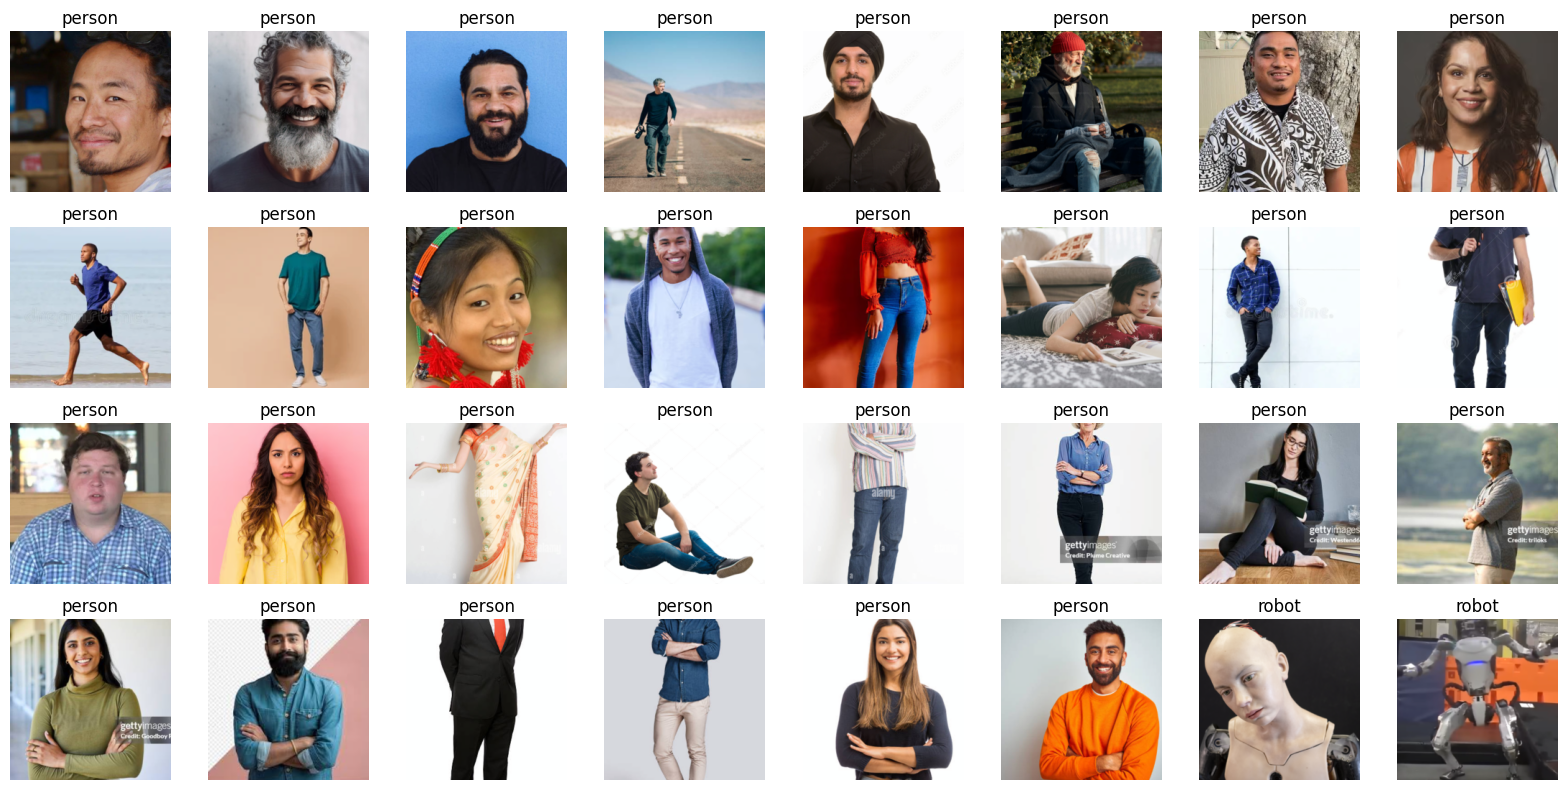

In [16]:
# Val Dataset

classNames = val_dataset.classes
inputs, classes = next(iter(val_loader))
titles = [classNames[x] for x in classes]

show_grid(inputs, titles=titles)

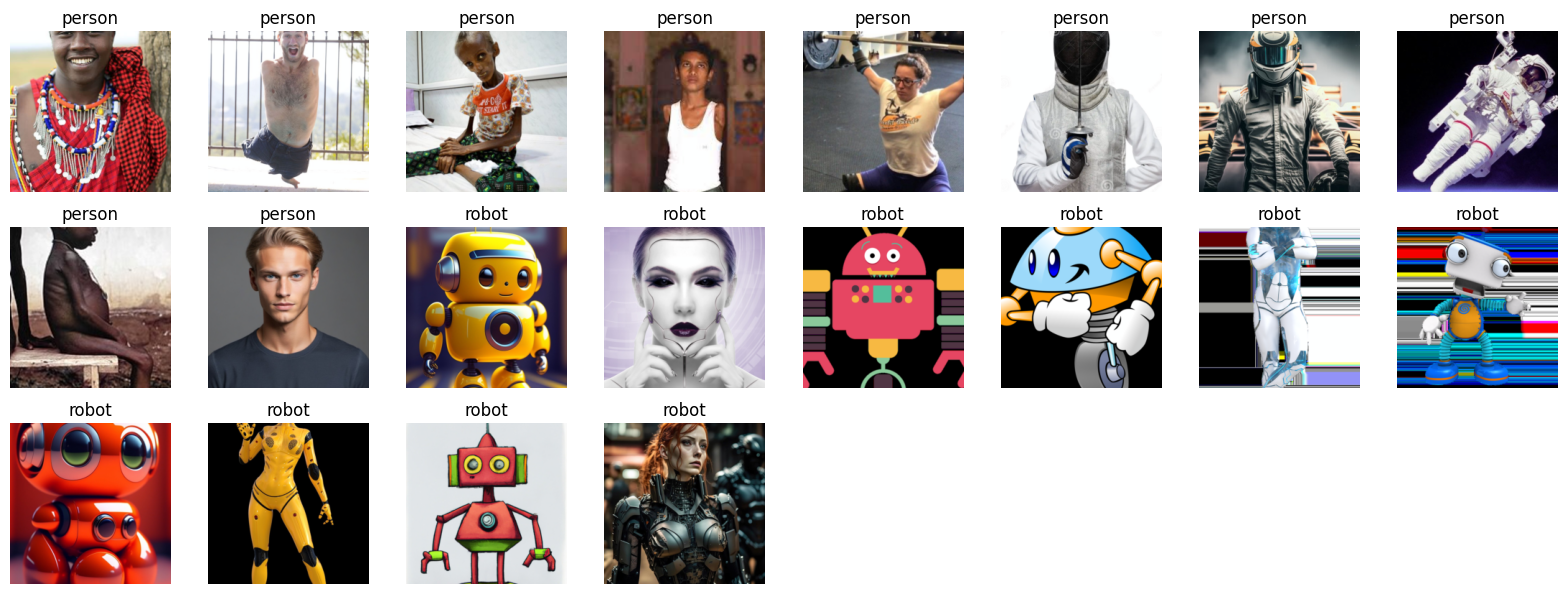

In [17]:
# blind dataset
classNames = blind_set.classes
inputs, classes = next(iter(blind_loader))
titles = [classNames[x] for x in classes]

show_grid(inputs, titles=titles, num=20)

### Analysis on saved models

#### Fe: Feature Extractor (5 epochs)
#### Ft: Feature Extractor (5 epochs) + Full FineTune (20 epochs) (total 25 epochs)
#### The vertical green line in Loss and Accuracy curves shows the switch in training methods

### Resnet-50

C:\Users\KZK-Y540\.conda\envs\nlp\Lib\site-packages\torchvision\models\_utils.py:208: UserWarning: The parameter 'pretrained' is deprecated since 0.13 and may be removed in the future, please use 'weights' instead.
  warnings.warn(
C:\Users\KZK-Y540\.conda\envs\nlp\Lib\site-packages\torchvision\models\_utils.py:223: UserWarning: Arguments other than a weight enum or `None` for 'weights' are deprecated since 0.13 and may be removed in the future. The current behavior is equivalent to passing `weights=None`.
  warnings.warn(msg)


Resnet model loaded successfully.
Resnet model loaded successfully.


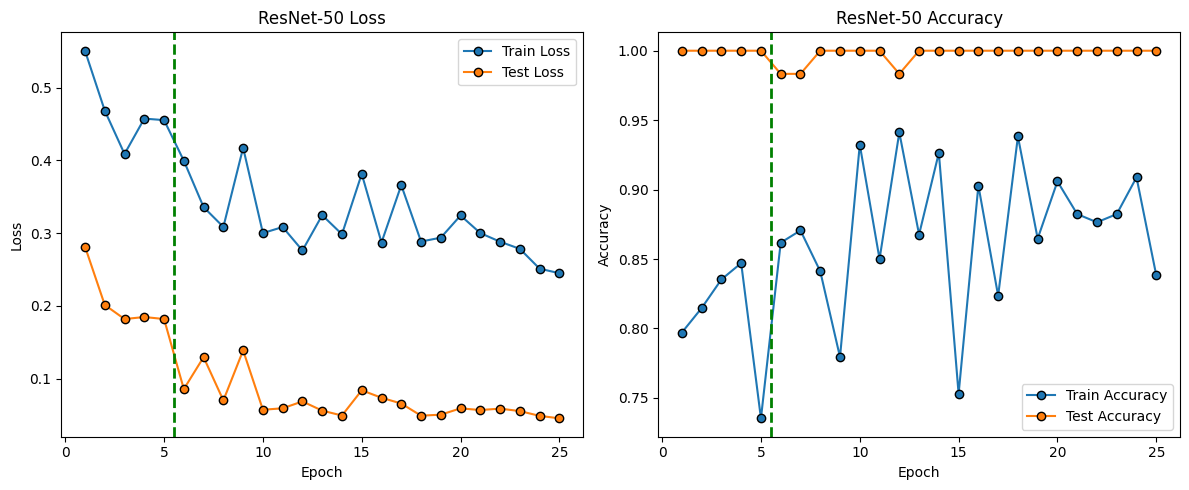

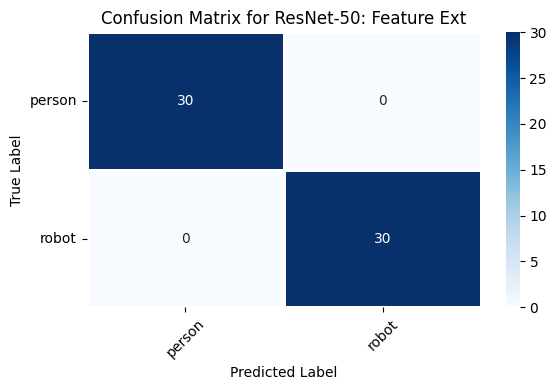

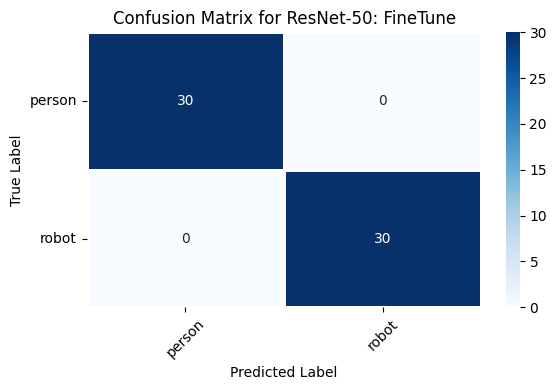


 --------------------------------------- 
 Prediction on Blind Set 
 ----------------------------------------------


C:\Users\KZK-Y540\.conda\envs\nlp\Lib\site-packages\torchvision\models\_utils.py:208: UserWarning: The parameter 'pretrained' is deprecated since 0.13 and may be removed in the future, please use 'weights' instead.
  warnings.warn(
C:\Users\KZK-Y540\.conda\envs\nlp\Lib\site-packages\torchvision\models\_utils.py:223: UserWarning: Arguments other than a weight enum or `None` for 'weights' are deprecated since 0.13 and may be removed in the future. The current behavior is equivalent to passing `weights=None`.
  warnings.warn(msg)


Resnet model loaded successfully.
Resnet model loaded successfully.


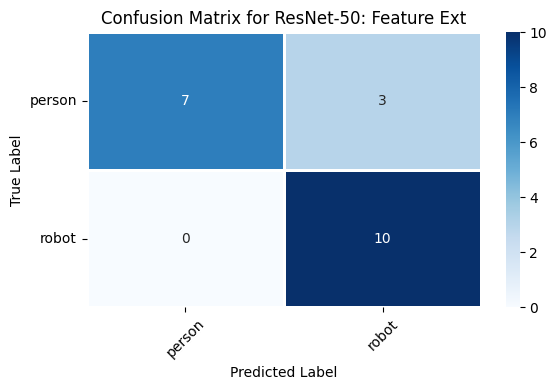

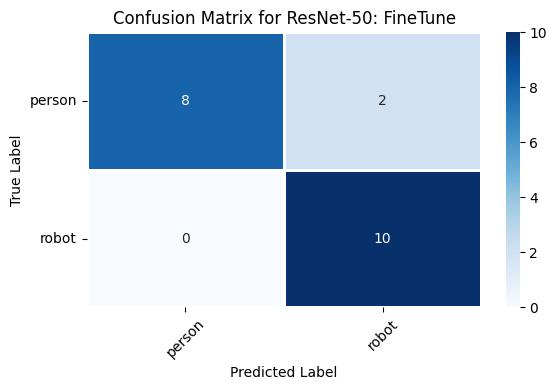


 --------------------------------------- 
 Display Misclassified Blind Set Images by Feature Extractor
 ----------------------------------------------


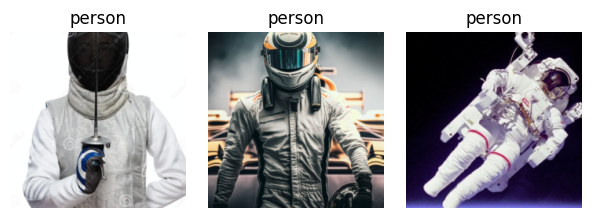


 --------------------------------------- 
 Display Misclassified Blind Set Images by Fine Tuning
 ----------------------------------------------


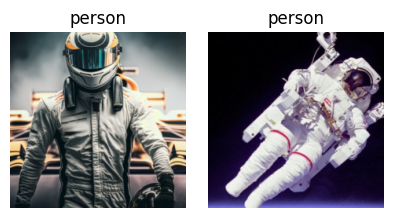

In [51]:
ft_path = "saved_models/full_finetune/resnet_final.pth"
fe_path = "saved_models/fixed_feature_extractor/resnet_final.pth"
result_path = "saved_models/resnet_training_results.csv"

displayModelPerformance(ft_path, fe_path, result_path, val_loader, "ResNet-50", "resnet")
print("\n --------------------------------------- \n Prediction on Blind Set \n ----------------------------------------------")
displayModelPerformance(ft_path, fe_path, result_path, blind_loader, "ResNet-50", "resnet", False)

### SqueezeNet

Squeezenet model loaded successfully.


C:\Users\KZK-Y540\.conda\envs\nlp\Lib\site-packages\torchvision\models\_utils.py:208: UserWarning: The parameter 'pretrained' is deprecated since 0.13 and may be removed in the future, please use 'weights' instead.
  warnings.warn(
C:\Users\KZK-Y540\.conda\envs\nlp\Lib\site-packages\torchvision\models\_utils.py:223: UserWarning: Arguments other than a weight enum or `None` for 'weights' are deprecated since 0.13 and may be removed in the future. The current behavior is equivalent to passing `weights=None`.
  warnings.warn(msg)


Squeezenet model loaded successfully.


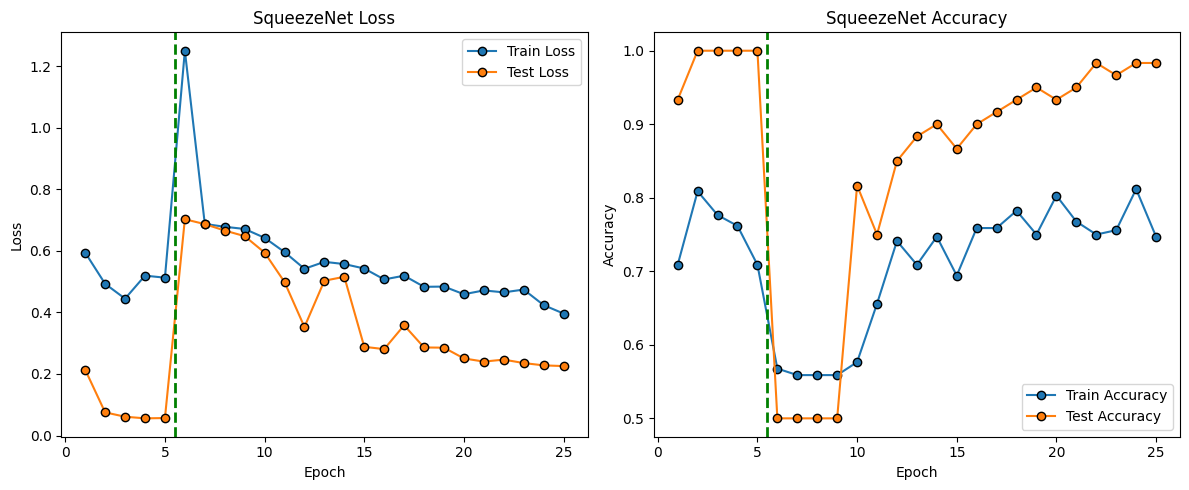

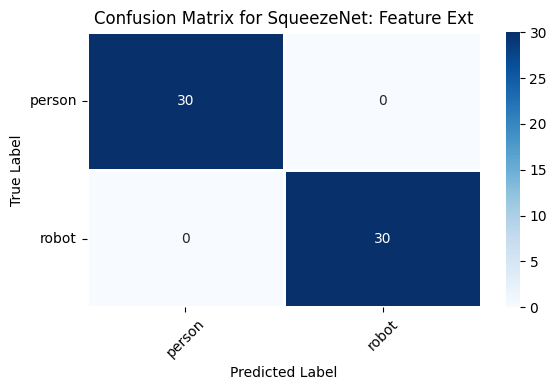

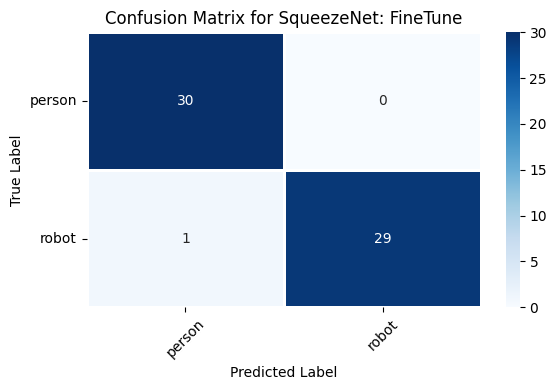


 --------------------------------------- 
 Prediction on Blind Set 
 ----------------------------------------------
Squeezenet model loaded successfully.
Squeezenet model loaded successfully.


C:\Users\KZK-Y540\.conda\envs\nlp\Lib\site-packages\torchvision\models\_utils.py:208: UserWarning: The parameter 'pretrained' is deprecated since 0.13 and may be removed in the future, please use 'weights' instead.
  warnings.warn(
C:\Users\KZK-Y540\.conda\envs\nlp\Lib\site-packages\torchvision\models\_utils.py:223: UserWarning: Arguments other than a weight enum or `None` for 'weights' are deprecated since 0.13 and may be removed in the future. The current behavior is equivalent to passing `weights=None`.
  warnings.warn(msg)


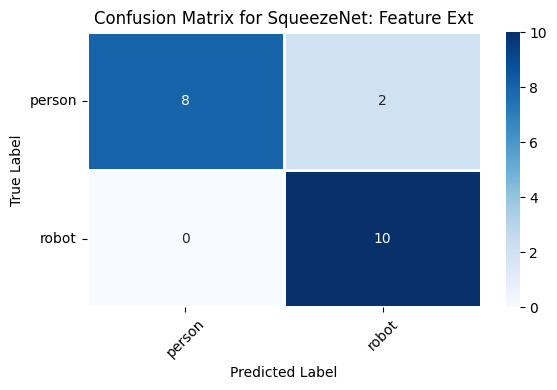

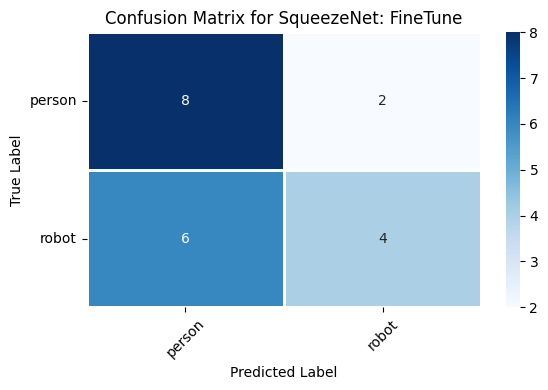


 --------------------------------------- 
 Display Misclassified Blind Set Images by Feature Extractor
 ----------------------------------------------


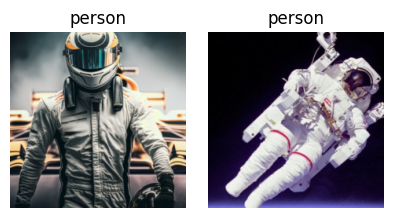


 --------------------------------------- 
 Display Misclassified Blind Set Images by Fine Tuning
 ----------------------------------------------


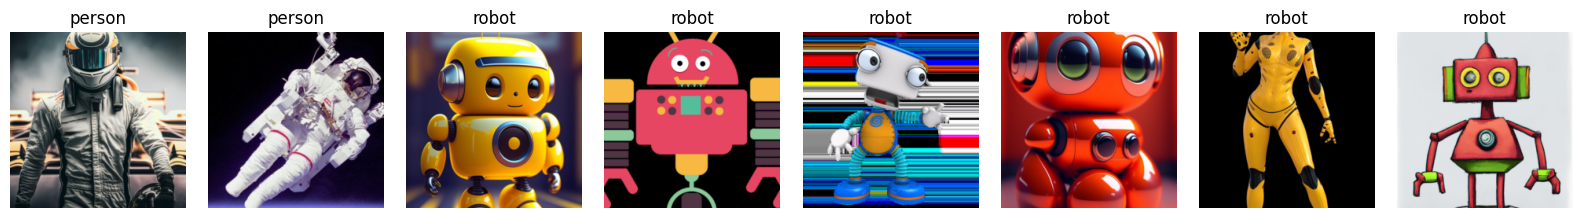

In [52]:
ft_path = "saved_models/full_finetune/squeezenet_final.pth"
fe_path = "saved_models/fixed_feature_extractor/squeezenet_final.pth"
result_path = "saved_models/squeezenet_training_results.csv"

displayModelPerformance(ft_path, fe_path, result_path, val_loader, "SqueezeNet", "squeezenet")
print("\n --------------------------------------- \n Prediction on Blind Set \n ----------------------------------------------")
displayModelPerformance(ft_path, fe_path, result_path, blind_loader, "SqueezeNet", "squeezenet", False) # blind set

### MobileNet-v2

C:\Users\KZK-Y540\.conda\envs\nlp\Lib\site-packages\torchvision\models\_utils.py:208: UserWarning: The parameter 'pretrained' is deprecated since 0.13 and may be removed in the future, please use 'weights' instead.
  warnings.warn(
C:\Users\KZK-Y540\.conda\envs\nlp\Lib\site-packages\torchvision\models\_utils.py:223: UserWarning: Arguments other than a weight enum or `None` for 'weights' are deprecated since 0.13 and may be removed in the future. The current behavior is equivalent to passing `weights=None`.
  warnings.warn(msg)


Mobilenetv2 model loaded successfully.
Mobilenetv2 model loaded successfully.


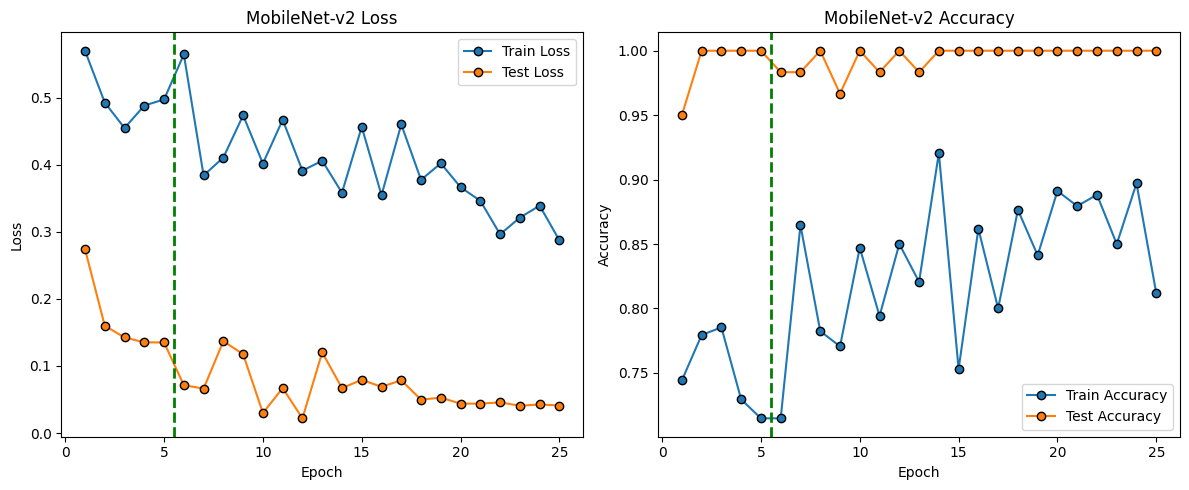

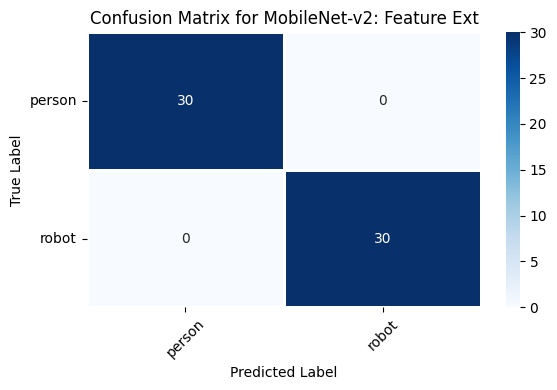

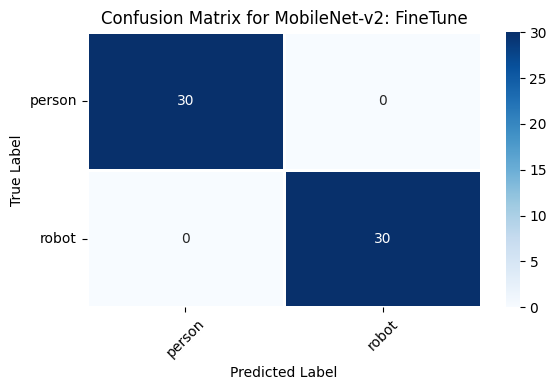


 --------------------------------------- 
 Prediction on Blind Set 
 ----------------------------------------------
Mobilenetv2 model loaded successfully.


C:\Users\KZK-Y540\.conda\envs\nlp\Lib\site-packages\torchvision\models\_utils.py:208: UserWarning: The parameter 'pretrained' is deprecated since 0.13 and may be removed in the future, please use 'weights' instead.
  warnings.warn(
C:\Users\KZK-Y540\.conda\envs\nlp\Lib\site-packages\torchvision\models\_utils.py:223: UserWarning: Arguments other than a weight enum or `None` for 'weights' are deprecated since 0.13 and may be removed in the future. The current behavior is equivalent to passing `weights=None`.
  warnings.warn(msg)


Mobilenetv2 model loaded successfully.


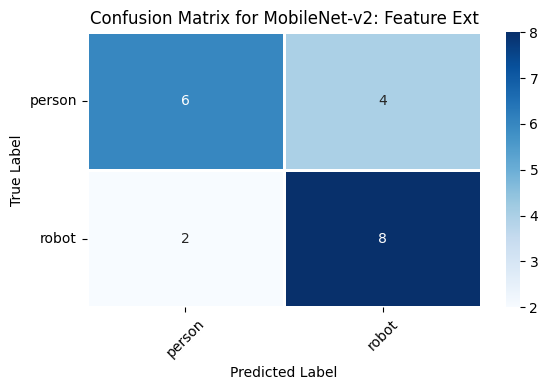

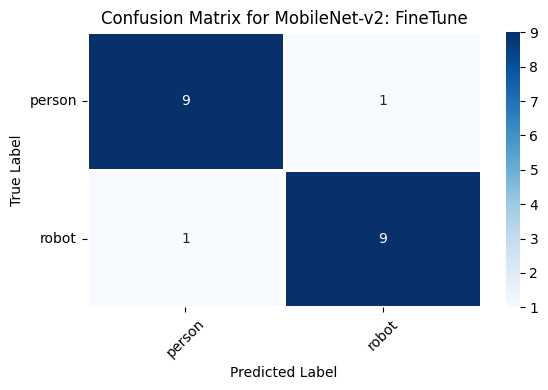


 --------------------------------------- 
 Display Misclassified Blind Set Images by Feature Extractor
 ----------------------------------------------


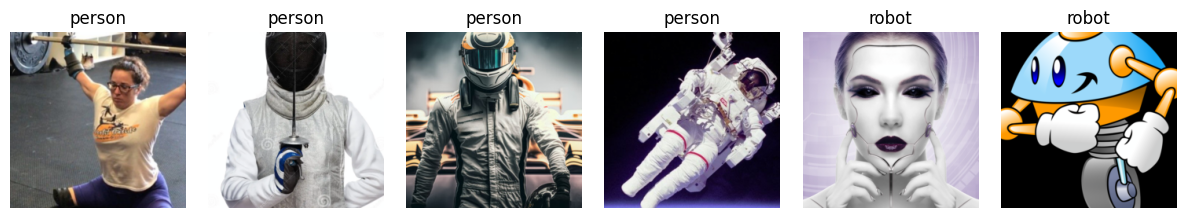


 --------------------------------------- 
 Display Misclassified Blind Set Images by Fine Tuning
 ----------------------------------------------


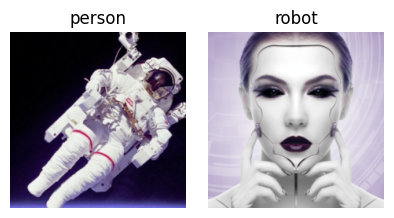

In [53]:
ft_path = "saved_models/full_finetune/mobilenet_final.pth"
fe_path = "saved_models/fixed_feature_extractor/mobilenet_final.pth"
result_path = "saved_models/mobilenet_training_results.csv"

displayModelPerformance(ft_path, fe_path, result_path, val_loader, "MobileNet-v2", "mobilenetv2")
print("\n --------------------------------------- \n Prediction on Blind Set \n ----------------------------------------------")
displayModelPerformance(ft_path, fe_path, result_path, blind_loader, "MobileNet-v2", "mobilenetv2", False)

### ConvNext

C:\Users\KZK-Y540\.conda\envs\nlp\Lib\site-packages\torchvision\models\_utils.py:208: UserWarning: The parameter 'pretrained' is deprecated since 0.13 and may be removed in the future, please use 'weights' instead.
  warnings.warn(
C:\Users\KZK-Y540\.conda\envs\nlp\Lib\site-packages\torchvision\models\_utils.py:223: UserWarning: Arguments other than a weight enum or `None` for 'weights' are deprecated since 0.13 and may be removed in the future. The current behavior is equivalent to passing `weights=None`.
  warnings.warn(msg)


Convnext model loaded successfully.
Convnext model loaded successfully.


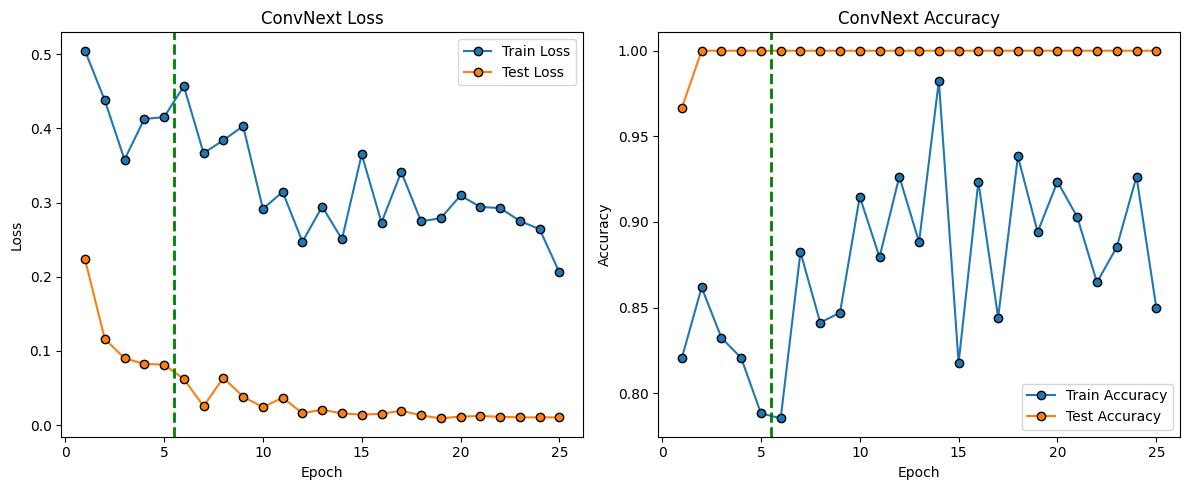

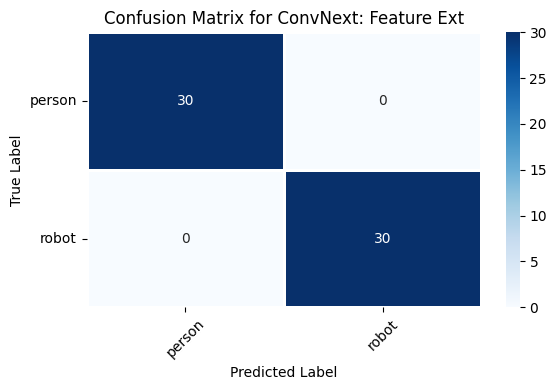

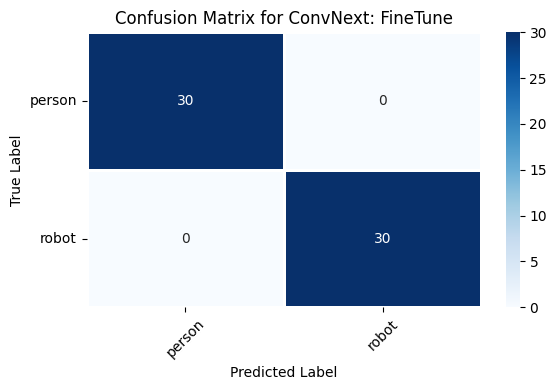


 --------------------------------------- 
 Prediction on Blind Set 
 ----------------------------------------------


C:\Users\KZK-Y540\.conda\envs\nlp\Lib\site-packages\torchvision\models\_utils.py:208: UserWarning: The parameter 'pretrained' is deprecated since 0.13 and may be removed in the future, please use 'weights' instead.
  warnings.warn(
C:\Users\KZK-Y540\.conda\envs\nlp\Lib\site-packages\torchvision\models\_utils.py:223: UserWarning: Arguments other than a weight enum or `None` for 'weights' are deprecated since 0.13 and may be removed in the future. The current behavior is equivalent to passing `weights=None`.
  warnings.warn(msg)


Convnext model loaded successfully.
Convnext model loaded successfully.


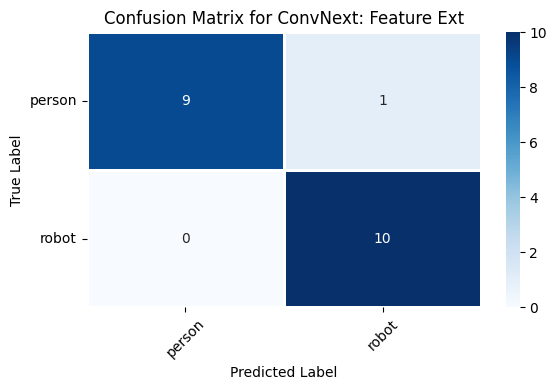

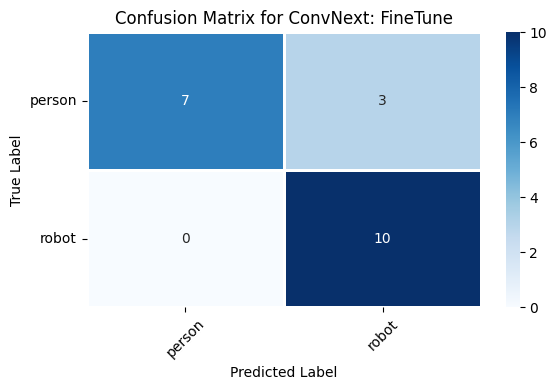


 --------------------------------------- 
 Display Misclassified Blind Set Images by Feature Extractor
 ----------------------------------------------


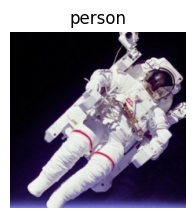


 --------------------------------------- 
 Display Misclassified Blind Set Images by Fine Tuning
 ----------------------------------------------


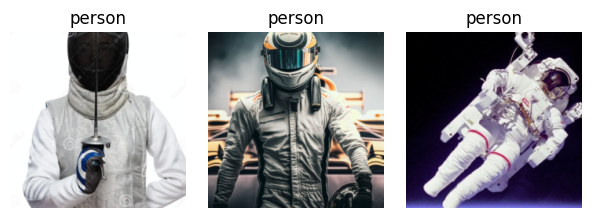

In [54]:
ft_path = "saved_models/full_finetune/convnext_final.pth"
fe_path = "saved_models/fixed_feature_extractor/convnext_final.pth"
result_path = "saved_models/convnext_training_results.csv"

displayModelPerformance(ft_path, fe_path, result_path, val_loader, "ConvNext", "convnext")
print("\n --------------------------------------- \n Prediction on Blind Set \n ----------------------------------------------")
displayModelPerformance(ft_path, fe_path, result_path, blind_loader, "ConvNext", "convnext", False)

### Vision Transformer (b_16)

C:\Users\KZK-Y540\.conda\envs\nlp\Lib\site-packages\torchvision\models\_utils.py:208: UserWarning: The parameter 'pretrained' is deprecated since 0.13 and may be removed in the future, please use 'weights' instead.
  warnings.warn(
C:\Users\KZK-Y540\.conda\envs\nlp\Lib\site-packages\torchvision\models\_utils.py:223: UserWarning: Arguments other than a weight enum or `None` for 'weights' are deprecated since 0.13 and may be removed in the future. The current behavior is equivalent to passing `weights=None`.
  warnings.warn(msg)


Vit model loaded successfully.
Vit model loaded successfully.


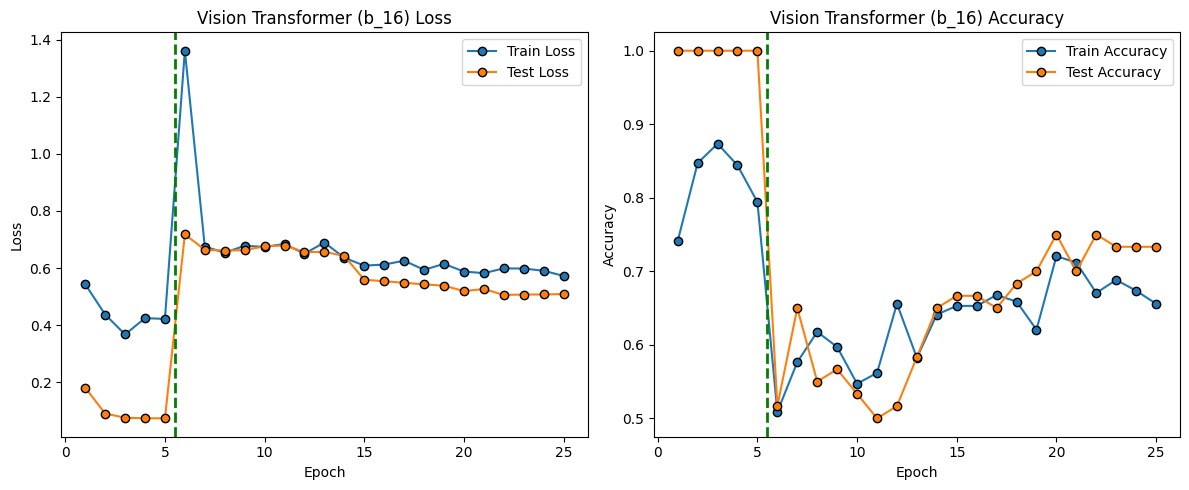

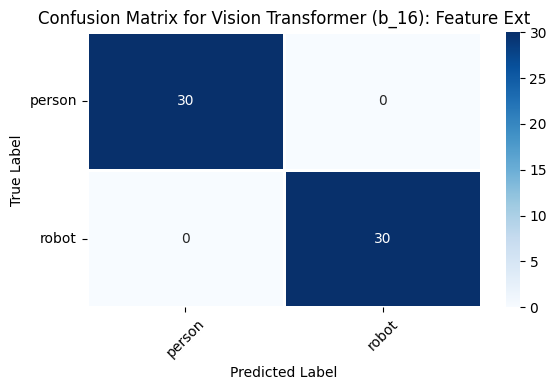

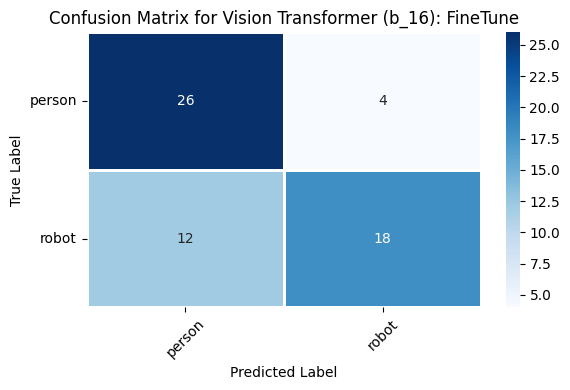


 --------------------------------------- 
 Prediction on Blind Set 
 ----------------------------------------------


C:\Users\KZK-Y540\.conda\envs\nlp\Lib\site-packages\torchvision\models\_utils.py:208: UserWarning: The parameter 'pretrained' is deprecated since 0.13 and may be removed in the future, please use 'weights' instead.
  warnings.warn(
C:\Users\KZK-Y540\.conda\envs\nlp\Lib\site-packages\torchvision\models\_utils.py:223: UserWarning: Arguments other than a weight enum or `None` for 'weights' are deprecated since 0.13 and may be removed in the future. The current behavior is equivalent to passing `weights=None`.
  warnings.warn(msg)


Vit model loaded successfully.
Vit model loaded successfully.


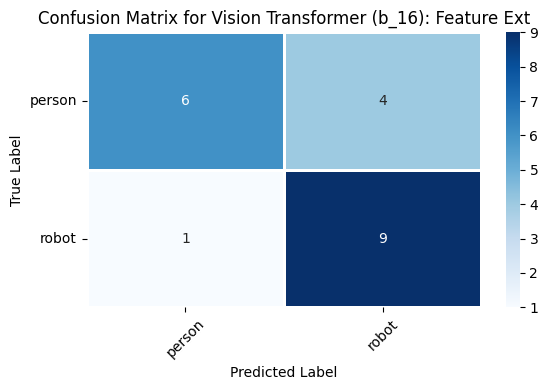

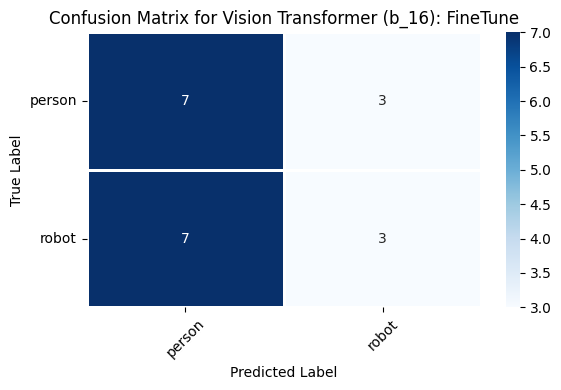


 --------------------------------------- 
 Display Misclassified Blind Set Images by Feature Extractor
 ----------------------------------------------


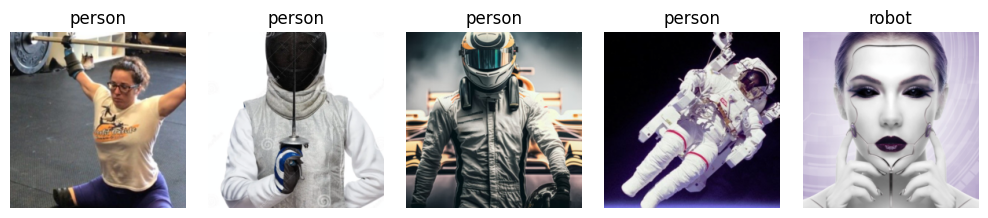


 --------------------------------------- 
 Display Misclassified Blind Set Images by Fine Tuning
 ----------------------------------------------


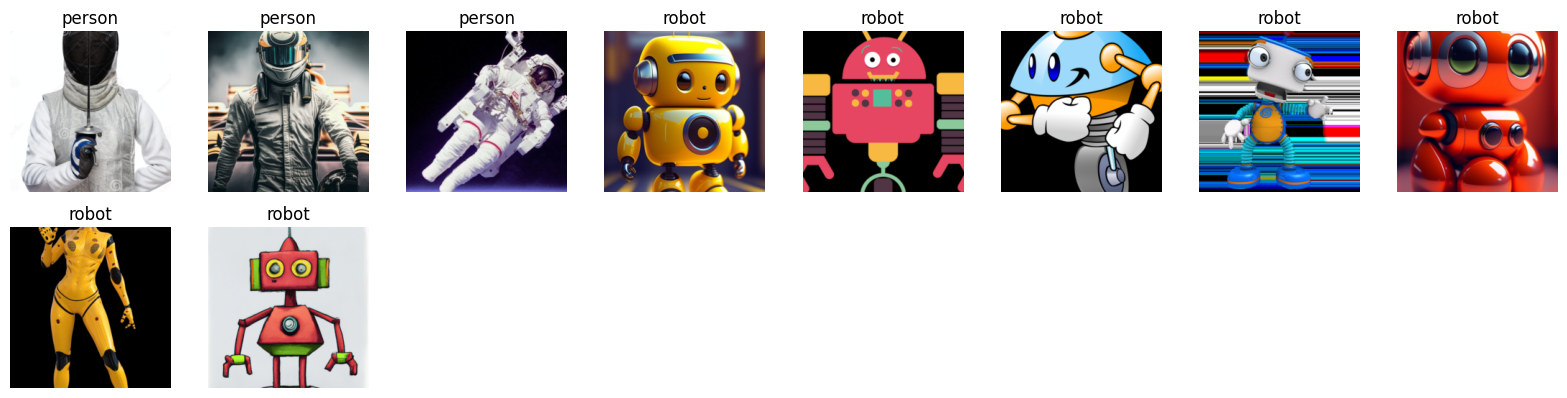

In [55]:
ft_path = "saved_models/full_finetune/vit_final.pth"
fe_path = "saved_models/fixed_feature_extractor/vit_final.pth"
result_path = "saved_models/vit_training_results.csv"

displayModelPerformance(ft_path, fe_path, result_path, val_loader, "Vision Transformer (b_16)", "vit")
print("\n --------------------------------------- \n Prediction on Blind Set \n ----------------------------------------------")
displayModelPerformance(ft_path, fe_path, result_path, blind_loader, "Vision Transformer (b_16)", "vit", False)

### Model Training

In [60]:
model, train_losses, test_losses, train_accuracies, test_accuracies = combine_training(
    model_name="mobilenet",
    train_loader=train_loader,
    test_loader=val_loader,
    lr=0.001,
    fixed_num_epochs=5,
    full_num_epochs=20,
    num_classes=2,
    freeze_feature_extractor=True,
    full_finetune=False,
    log_dir="logs",
    save_path="resnet_compare"
)

Downloading: "https://download.pytorch.org/models/mobilenet_v2-b0353104.pth" to C:\Users\KZK-Y540/.cache\torch\hub\checkpoints\mobilenet_v2-b0353104.pth
100%|█████████████████████████████████████████████████████████████████████████████| 13.6M/13.6M [00:01<00:00, 9.66MB/s]


Using mobilenet as a fixed feature extractor.
Are all weights frozen? True
Training with fixed feature extractor...


 20%|████████████████▊                                                                   | 1/5 [00:21<01:27, 21.88s/it]

Epoch 1/5
Train Loss: 0.8030, Train Accuracy: 0.5676
Test Loss: 0.6876, Test Accuracy: 0.5167
Learning Rate: 0.001000


 40%|█████████████████████████████████▌                                                  | 2/5 [00:43<01:05, 21.83s/it]

Epoch 2/5
Train Loss: 0.6874, Train Accuracy: 0.5676
Test Loss: 0.3841, Test Accuracy: 0.9167
Learning Rate: 0.000905


 60%|██████████████████████████████████████████████████▍                                 | 3/5 [01:07<00:45, 22.57s/it]

Epoch 3/5
Train Loss: 0.5395, Train Accuracy: 0.7382
Test Loss: 0.2852, Test Accuracy: 0.9833
Learning Rate: 0.000655


 80%|███████████████████████████████████████████████████████████████████▏                | 4/5 [01:31<00:23, 23.12s/it]

Epoch 4/5
Train Loss: 0.5134, Train Accuracy: 0.7588
Test Loss: 0.2718, Test Accuracy: 0.9667
Learning Rate: 0.000345


100%|████████████████████████████████████████████████████████████████████████████████████| 5/5 [01:53<00:00, 22.61s/it]

Epoch 5/5
Train Loss: 0.4524, Train Accuracy: 0.8000
Test Loss: 0.2507, Test Accuracy: 0.9667
Learning Rate: 0.000095
Model saved to resnet_compare/fixed_feature_extractor\mobilenet_final.pth
Fixed feature extractor training completed in 113.08 seconds.


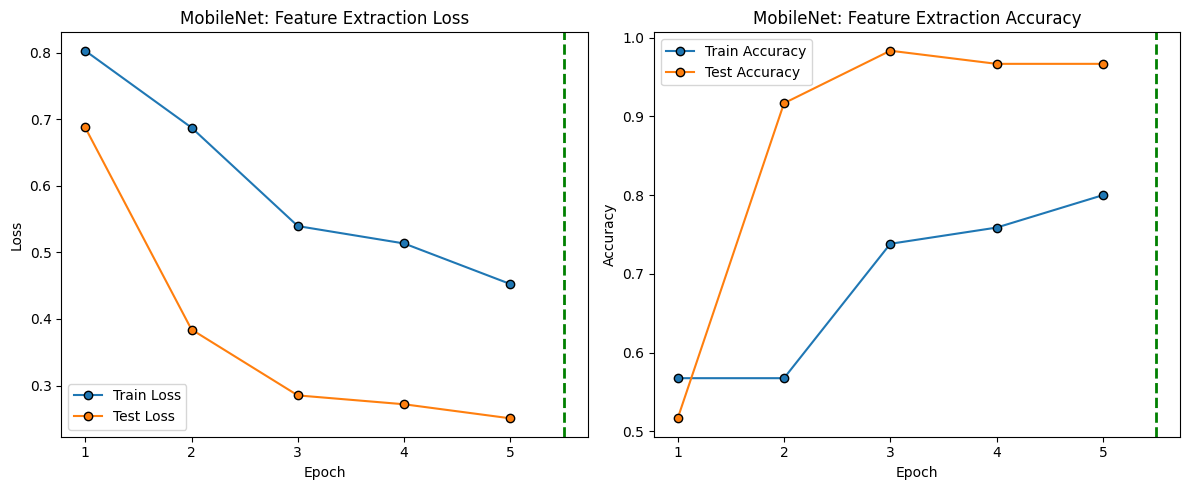

In [61]:
dict = {'Train Loss': train_losses, 'Test Loss': test_losses, 'Train Accuracy': train_accuracies, 'Test Accuracy': test_accuracies}
df = pd.DataFrame(dict)

plot_performance(df, "MobileNet: Feature Extraction")

In [63]:
model, train_loss, test_loss, train_accuracy, test_accuracy = combine_training(
    model_name="mobilenet",
    train_loader=train_loader,
    test_loader=val_loader,
    lr=0.001,
    fixed_num_epochs=5,
    full_num_epochs=10,
    num_classes=2,
    freeze_feature_extractor=False,
    full_finetune=True,
    log_dir="logs",
    save_path="resnet_compare"
)

Fine-tuning the entire mobilenet model.
All parameters set to requires_grad=True: True
Training with full fine-tuning...


 10%|████████▎                                                                          | 1/10 [00:32<04:54, 32.67s/it]

Epoch 1/10
Train Loss: 0.5291, Train Accuracy: 0.7618
Test Loss: 0.1849, Test Accuracy: 0.9167
Learning Rate: 0.000500


 20%|████████████████▌                                                                  | 2/10 [01:08<04:34, 34.25s/it]

Epoch 2/10
Train Loss: 0.4439, Train Accuracy: 0.7882
Test Loss: 0.0549, Test Accuracy: 1.0000
Learning Rate: 0.000488


 20%|████████████████▌                                                                  | 2/10 [01:28<05:52, 44.05s/it]


KeyboardInterrupt: 

In [ ]:
dict = {'Train Loss': train_loss, 'Test Loss': test_loss, 'Train Accuracy': train_accuracy, 'Test Accuracy': test_accuracy}
df = pd.DataFrame(dict)

plot_performance(df, "MobileNet: Fine Tuning")

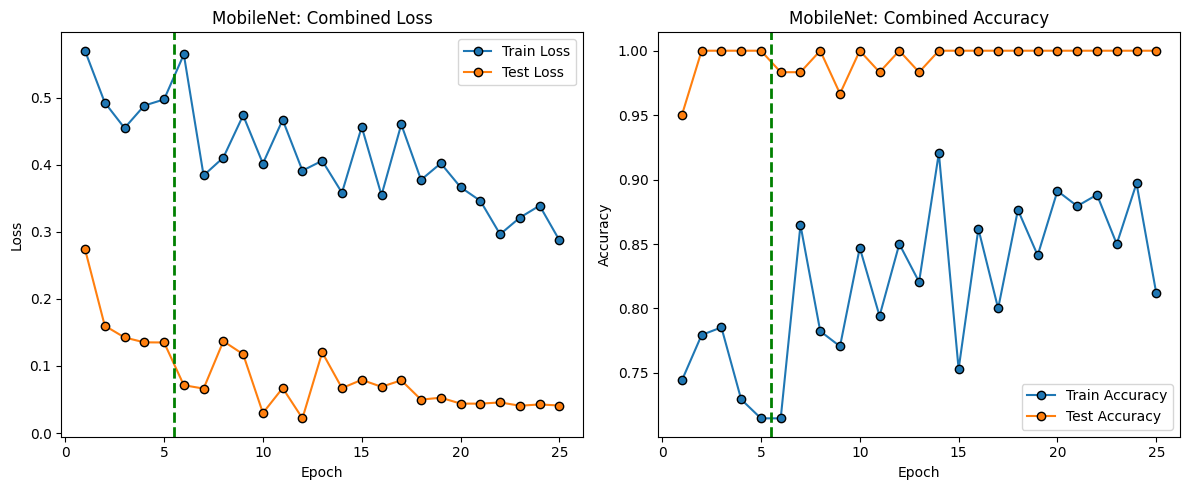

In [64]:
result_path = "saved_models/mobilenet_training_results.csv"

metrics = pd.read_csv(result_path)
plot_performance(metrics, "MobileNet: Combined")

## Observations:

1) Test Accuracy \
   Almost all models perform with extremely high accuracy (100% in most cases) on the test set except FineTuned Vision Transformer. \
The reason for low accuracy of Vision Transformer is that it has too many parameters which overfit on the small finetuning data and produce low accuracy. \
This is supported byt he fact that just Feature Extraction on Vision Transformer gives 100% accuracy.

2) Train Accuracy \
   All models have lower train accuracy then the test accuracy. We don't really have an explanation for this but we can argue that models find our dataset in the training dataset more diverse than the ones in our test dataset.

3) Train-Test Experiment (Not Shown) \
   To analyse the uncanny model performance on train-test data, we decided to switch the train and test data for the ResNet model and see what happens. So now train data has 30 images and test data has 150. The ResNet model gave a train accuracy of 0.78 and a test accuracy of 0.92 (remember, the dataset is switched!). We did not know how to interpret this result except that it was consistent with the original experiments (high test accuracy, low train accuracy).

4) Blind Set \
   ResNet and ConvNext were the best performers on the blind set. Both classified on the images of a Fencing Sportsman, an Astronaut and a Race-Car driver as Robots which was expected. Their ability to clasify the "finger-on-the-face" ultra-realistic humanoid was impressive. Other models found this task difficult.